### Transfer learning
In this notebook, we use the rnn trained on the MITBIH and fine tune it to the PTBDB dataset.

In [3]:
import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras import optimizers, losses, activations, models, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, GRU, \
    concatenate, Add, Activation
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches
import sklearn.decomposition as decomposition

In [4]:
df_1 = pd.read_csv("data/ptbdb_normal.csv", header=None)
df_2 = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

### Load model and skip to [evaluation](#evaluate)

In [7]:
full_model = load_model('rnn_transfer.h5')

### Or ALTERNATIVELY train it
#### Please skip to Evaluate if you don't want to retrain the model

In [92]:
base_model = load_model("rnn/rnn_mitbih.h5")

#### Remove dense layers and freeze remaining layers

In [95]:
cropped_model = Model(model.input, model.layers[3].output)
for i in range(3):
    cropped_model.layers[i].trainable = False

In [96]:
cropped_model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_input (InputLayer)       [(None, 187, 1)]          0         
_________________________________________________________________
gru (GRU)                    (None, 187, 128)          50304     
_________________________________________________________________
gru_1 (GRU)                  (None, 187, 128)          99072     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               99072     
Total params: 248,448
Trainable params: 0
Non-trainable params: 248,448
_________________________________________________________________


In [97]:
seq_len = 187

def get_model():
    n_class = 1
    
    x = cropped_model.output
    dense = Dense(64, activation='relu')(x)
    dense = Dropout(0.2)(dense)
    output = Dense(n_class, activation='sigmoid')(dense)
    
    opt = tensorflow.keras.optimizers.Adam(lr=0.001)
    
    full_model = models.Model(inputs=cropped_model.input, outputs=output)
    class_weights = compute_class_weight('balanced', [0, 1], Y)

    full_model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['accuracy']
    )
    full_model.summary()
    return full_model

In [ ]:
full_model = get_model()
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [early, redonplat]  # early

full_model.fit(X, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1)

#### Unfreeze layers and continue training

In [ ]:
for i in range(3):
    full_model.layers[i].trainable = True

In [ ]:
file_path = "rnn_transfer_retrain.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [checkpoint, early, redonplat]  # early

full_model.fit(X, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1)
full_model.load_weights(file_path)

### Evaluate
<a id='evaluate'></a>

In [6]:
pred_test = full_model.predict(X_test)
pred_test = (pred_test>0.5).astype(np.int8)

f1 = f1_score(Y_test, pred_test)

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

auc_roc = roc_auc_score(Y_test, pred_test)

print("AUROC score : %s "% auc_roc)

precision, recall, _ = precision_recall_curve(Y_test, pred_test)

auc_prc = auc(recall, precision)
print("AUPRC score : %s "% auc_prc)

print(confusion_matrix(Y_test, pred_test))

Test f1 score : 0.9089676982154958 
Test accuracy score : 0.8615596015115081 
AUROC score : 0.7851431152154814 
AUPRC score : 0.92673859465013 
[[ 496  313]
 [  90 2012]]


### Visualize ptbdb embeddings from a model trained on the mitbih dataset
We now look at the embeddings for the PITBDB dataset generated from training on the larger MITBIH model.

We do this for the baseline cnn model and for the rnn used above for transfer learning, both before and after training for the PTBDB dataset.

In [32]:
subset_size = 5000
subset = np.random.randint(X.shape[0], size=(subset_size))

In [33]:
base_model = load_model("rnn/rnn_mitbih.h5")
embeding_model = Model(inputs=base_model.inputs, outputs=base_model.layers[3].output) # get embeddings from last GRU layer

embedings = embeding_model.predict(X[subset])
X_centered = embedings - embedings.mean(axis=0)

pca = decomposition.PCA(n_components=50)
embedings_reduced = pca.fit_transform(X_centered)
t_sne_rnn = TSNE(n_components=2).fit_transform(embedings_reduced)

In [34]:
embeding_model = Model(inputs=full_model.inputs, outputs=full_model.layers[3].output) # get embeddings from last GRU layer

embedings = embeding_model.predict(X[subset])
X_centered = embedings - embedings.mean(axis=0)

pca = decomposition.PCA(n_components=50)
embedings_reduced = pca.fit_transform(X_centered)
t_sne_transfer = TSNE(n_components=2).fit_transform(embedings_reduced)

In [35]:
baseline_model = load_model("baseline/baseline_cnn_mitbih.h5")
embeding_model = Model(inputs=baseline_model.inputs, outputs=baseline_model.layers[15].output) # get embeddings from last conv layer

embedings = embeding_model.predict(X[subset])
X_centered = embedings - embedings.mean(axis=0)

pca = decomposition.PCA(n_components=50)
embedings_reduced = pca.fit_transform(X_centered)
t_sne_baseline = TSNE(n_components=2).fit_transform(embedings_reduced)

We clearly observe that, even though the first model was trained on a different dataset, it is still able to create somewhat meaninful embeddings for this task.

After fine tuning this model for the ptbdb dataset, we achieve clearer separations between tasks.

However, the CNN baseline model is still able to create embeddings which show a clearer separation between classes, despite not being fine tuned for this dataset.

Text(0.5, 1.0, 'Baseline CNN for MITBIH')

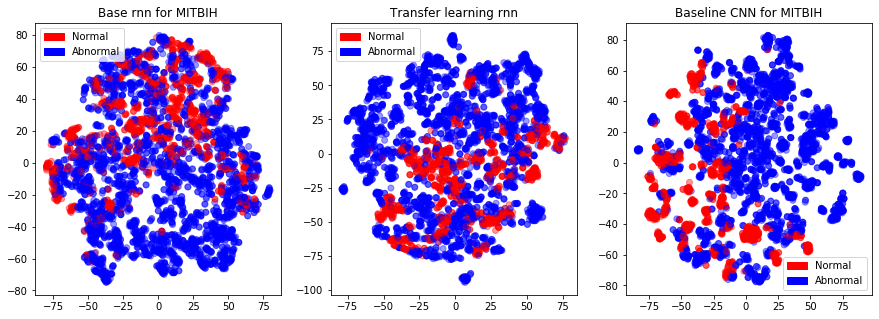

In [36]:
colors = ['r', 'b']
label_names = ['Normal', 'Abnormal']
colors_artists = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(2)]

fig,a = plt.subplots(1,3)
fig.set_figheight(5)
fig.set_figwidth(15)

a[0].scatter([t_sne_rnn[i, 0] for i in range(subset_size)], [t_sne_rnn[i, 1] for i in range(subset_size)],
                 c=[colors[Y[subset[i]]] for i in range(subset_size)], label=[Y[subset[i]] for i in range(subset_size)], alpha=0.4)
a[0].legend(handles=colors_artists)
a[0].set_title('Base rnn for MITBIH')

a[1].scatter([t_sne_transfer[i, 0] for i in range(subset_size)], [t_sne_transfer[i, 1] for i in range(subset_size)],
                 c=[colors[Y[subset[i]]] for i in range(subset_size)], label=[Y[subset[i]] for i in range(subset_size)], alpha=0.4)
a[1].legend(handles=colors_artists)
a[1].set_title('Transfer learning rnn')

a[2].scatter([t_sne_baseline[i, 0] for i in range(subset_size)], [t_sne_baseline[i, 1] for i in range(subset_size)],
                 c=[colors[Y[subset[i]]] for i in range(subset_size)], label=[Y[subset[i]] for i in range(subset_size)], alpha=0.4)
a[2].legend(handles=colors_artists)
a[2].set_title('Baseline CNN for MITBIH')